# Predicting NBA Game Winners

In [1]:
# Load necessary libraries

""""import platform
import numpy as np
import pandas as pd
import sklearn as sk
import os"""

import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import os


In [2]:
print("Python:{}".format(platform.python_version()))
print("Pandas:{}".format(pd.__version__))
print("sklearn:{}".format(sk.__version__))

Python:3.10.12
Pandas:2.0.3
sklearn:1.2.2


In [3]:
# Load the dataset: NBA statistics from the 2013-2014 basketball season
df = pd.read_csv('NBA Regular Season Results 2013-2014.csv')

In [4]:
from sklearn.metrics import f1_score, make_scorer, classification_report

scorer = make_scorer(f1_score, pos_label = None, average = 'weighted')

In [5]:
# Examine the dataset with its initial formatting
df.head()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
0,Tue Oct 29 2013,7:00 pm,Orlando Magic,87,Indiana Pacers,97,Box Score,NaN,18165,NaN
1,Tue Oct 29 2013,10:30 pm,Los Angeles Clippers,103,Los Angeles Lakers,116,Box Score,NaN,18997,NaN
2,Tue Oct 29 2013,8:00 pm,Chicago Bulls,95,Miami Heat,107,Box Score,NaN,19964,NaN
3,Wed Oct 30 2013,7:00 pm,Brooklyn Nets,94,Cleveland Cavaliers,98,Box Score,NaN,20562,NaN
4,Wed Oct 30 2013,8:30 pm,Atlanta Hawks,109,Dallas Mavericks,118,Box Score,NaN,19834,NaN


In [6]:
df.dtypes

# Note the Date is read as an object field

Date               object
Start (ET)         object
Visitor/Neutral    object
PTS                 int64
Home/Neutral       object
PTS.1               int64
Unnamed: 6         object
Unnamed: 7         object
Attend.             int64
Notes              object
dtype: object

In [7]:
# Don't read the first row because it is blank, and read the date column as a date

df = pd.read_csv('NBA Regular Season Results 2013-2014.csv', parse_dates = ['Date'])

# Correct column names
df.columns = ['Date', 'Start Time (ET)', 'Visitor Team', 'Visitor Score', 'Home Team', 'Home Score', 'Box Score',
              'OT', 'Attendance', 'Notes']

In [8]:
df.shape

(1230, 10)

In [9]:
# View the updated dataset
df.head()

,Date,Start Time (ET),Visitor Team,Visitor Score,Home Team,Home Score,Box Score,OT,Attendance,Notes
0,2013-10-29,7:00 pm,Orlando Magic,87,Indiana Pacers,97,Box Score,NaN,18165,NaN
1,2013-10-29,10:30 pm,Los Angeles Clippers,103,Los Angeles Lakers,116,Box Score,NaN,18997,NaN
2,2013-10-29,8:00 pm,Chicago Bulls,95,Miami Heat,107,Box Score,NaN,19964,NaN
3,2013-10-30,7:00 pm,Brooklyn Nets,94,Cleveland Cavaliers,98,Box Score,NaN,20562,NaN
4,2013-10-30,8:30 pm,Atlanta Hawks,109,Dallas Mavericks,118,Box Score,NaN,19834,NaN


In [10]:
# The Date field has been updated to read as a datetime field
# May not do anything with the field yet
df.dtypes

Date               datetime64[ns]
Start Time (ET)            object
Visitor Team               object
Visitor Score               int64
Home Team                  object
Home Score                  int64
Box Score                  object
OT                         object
Attendance                  int64
Notes                      object
dtype: object

In [11]:
# Create new feature that notes whether the home team won
df['Home Win'] = df['Visitor Score'] < df['Home Score']

# Assign "class values" to the Home Win column

### This will also be the value that we want to predict ###
y_true = df['Home Win'].values

In [12]:
# Review new column with correctly populated fields
df.head()

,Date,Start Time (ET),Visitor Team,Visitor Score,Home Team,Home Score,Box Score,OT,Attendance,Notes,Home Win
0,2013-10-29,7:00 pm,Orlando Magic,87,Indiana Pacers,97,Box Score,NaN,18165,NaN,True
1,2013-10-29,10:30 pm,Los Angeles Clippers,103,Los Angeles Lakers,116,Box Score,NaN,18997,NaN,True
2,2013-10-29,8:00 pm,Chicago Bulls,95,Miami Heat,107,Box Score,NaN,19964,NaN,True
3,2013-10-30,7:00 pm,Brooklyn Nets,94,Cleveland Cavaliers,98,Box Score,NaN,20562,NaN,True
4,2013-10-30,8:30 pm,Atlanta Hawks,109,Dallas Mavericks,118,Box Score,NaN,19834,NaN,True


## What is the baseline?

How frequently do the home teams win? Typically, the assumption is that home teams will win more often than not

In [13]:
# Establishing the baseline win percentage for the Home Teams overall
n_games = df['Home Win'].count()
n_homewins = df['Home Win'].sum()
win_percentage = n_homewins / n_games

print('Home Win percentage: {0:.2f}%'.format(100 * win_percentage))

Home Win percentage: 58.05%


The home teams' win percentage is 58.05%. If a model is considered useful, it must (at minimum) have a better score than the established baseline

In [14]:
# Predicting the baseline for Home Teams wins with simple classifier

from sklearn.metrics import f1_score

y_pred = [1] * len(y_true)
print('F1: {0:.4f}%'.format(f1_score(y_true, y_pred, pos_label = None, average = 'weighted') * 100))

F1: 42.6408%


The calculated F1 score of 42.6% is the score to beat.

## Creating More Features

In [15]:
# Create two new columns, with all of the values set to False
df['Home Last Win'] = False
df['Visitor Last Win'] = False

In [16]:
# Determining whether the home and visitor teams won their last games
# This will update the Home Last Win & Visitor Last Win columns to either remain False or change to True

from collections import defaultdict

won_last = defaultdict(int)   # The default value of int is 0

# Inefficient method to deterime previous wins
for index, row in df.iterrows():
    home_team = row['Home Team']
    visitor_team = row['Visitor Team']
    row['Home Last Win'] = won_last[home_team]
    row['Visitor Last Win'] = won_last[visitor_team]
    # Set current win
    won_last[home_team] = row['Home Win']
    won_last[visitor_team] = not row['Home Win']
df.loc[20:25]

,Date,Start Time (ET),Visitor Team,Visitor Score,Home Team,Home Score,Box Score,OT,Attendance,Notes,Home Win,Home Last Win,Visitor Last Win
20,2013-11-01,7:30 pm,Milwaukee Bucks,105,Boston Celtics,98,Box Score,NaN,18624,NaN,False,False,False
21,2013-11-01,8:00 pm,Miami Heat,100,Brooklyn Nets,101,Box Score,NaN,17732,NaN,True,False,False
22,2013-11-01,7:00 pm,Cleveland Cavaliers,84,Charlotte Bobcats,90,Box Score,NaN,18017,NaN,True,False,False
23,2013-11-01,9:00 pm,Portland Trail Blazers,113,Denver Nuggets,98,Box Score,NaN,19155,NaN,False,False,False
24,2013-11-01,8:00 pm,Dallas Mavericks,105,Houston Rockets,113,Box Score,NaN,18142,NaN,True,False,False
25,2013-11-01,10:30 pm,San Antonio Spurs,91,Los Angeles Lakers,85,Box Score,NaN,18997,NaN,False,False,False


In [17]:
df.loc[90:95][['Date', 'Visitor Team', 'Visitor Score', 'Home Team', 'Home Score',
               'Home Win', 'Home Last Win', 'Visitor Last Win']]

,Date,Visitor Team,Visitor Score,Home Team,Home Score,Home Win,Home Last Win,Visitor Last Win
90,2013-11-09,Dallas Mavericks,91,Milwaukee Bucks,83,False,False,False
91,2013-11-09,Portland Trail Blazers,96,Sacramento Kings,85,False,False,False
92,2013-11-09,Utah Jazz,91,Toronto Raptors,115,True,False,False
93,2013-11-10,Minnesota Timberwolves,113,Los Angeles Lakers,90,False,False,False
94,2013-11-10,San Antonio Spurs,120,New York Knicks,89,False,False,False
95,2013-11-10,Washington Wizards,105,Oklahoma City Thunder,106,True,False,False


# Basic Classification with a Decision Tree

The default settings for the Decision Tree will be used for the home wins, winning streaks, and rankings

In [18]:
# Basic Decision Tree Classifier set up
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 14) # Remove random_state to get non-replicable results

In [19]:
#from sklearn.cross_validation import cross_val_score

# Use selected features as input for the classifier (target)
#X_previouswins = df[['Home Last Win', 'Visitor Last Win']].values

# Decision Tree Classifier
#dtc = DecisionTreeClassifier(random_state = 14)
#scores = cross_val_score(dtc, X_previouswins, y_true, scoring = scorer)

# Print results
#print("Using just the last result from the home and visitor teams")
#print('F1: {0:.4f}%'.format(np.mean(scores) * 100))

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Use selected features as input for the classifier (target)
X_previouswins = df[['Home Last Win', 'Visitor Last Win']].values

# Assuming y_true is defined somewhere in your code
# It represents the true labels/targets for your dataset

# Define your scoring function 'scorer'
scorer = 'f1'  # or any other appropriate scoring function

# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(dtc, X_previouswins, y_true, scoring=scorer)

# Print results
print("Using just the last result from the home and visitor teams")
print('F1: {0:.4f}%'.format(np.mean(scores) * 100))


Using just the last result from the home and visitor teams
F1: 73.4567%


When using the features that deterime whether a team won their previous game, the result has improved

### Decision Tree Classifier: Considerating Winning Streaks

In [21]:
# Taking into consideration winning streaks - What are the teams' win streaks coming into the game?
df["Home Win Streak"] = 0
df["Visitor Win Streak"] = 0

# Did the home and visitor teams win their last game?
from collections import defaultdict
win_streak = defaultdict(int)

for index, row in df.iterrows():  # Note that this is not the most efficient method
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["Home Win Streak"] = win_streak[home_team]
    row["Visitor Win Streak"] = win_streak[visitor_team]
    df.loc[index] = row

    # Set current win streak
    if row["Home Win"]:
        win_streak[home_team] += 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1

In [22]:
df.loc[50:60][['Date', 'Visitor Team', 'Visitor Score', 'Home Team', 'Home Score',
               'Home Win', 'Home Win Streak', 'Visitor Win Streak']]

,Date,Visitor Team,Visitor Score,Home Team,Home Score,Home Win,Home Win Streak,Visitor Win Streak
50,2013-11-05,Utah Jazz,88,Brooklyn Nets,104,True,0,0
51,2013-11-05,Los Angeles Lakers,104,Dallas Mavericks,123,True,1,1
52,2013-11-05,San Antonio Spurs,102,Denver Nuggets,94,False,0,0
53,2013-11-05,Indiana Pacers,99,Detroit Pistons,91,False,1,3
54,2013-11-05,Phoenix Suns,104,New Orleans Pelicans,98,False,1,0
55,2013-11-05,Charlotte Bobcats,102,New York Knicks,97,False,0,0
56,2013-11-05,Houston Rockets,116,Portland Trail Blazers,101,False,2,0
57,2013-11-05,Atlanta Hawks,105,Sacramento Kings,100,False,0,0
58,2013-11-05,Miami Heat,104,Toronto Raptors,95,False,1,1
59,2013-11-06,Utah Jazz,87,Boston Celtics,97,True,0,0


In [23]:
# Use selected features as input for the classifier (target)
X_winstreak = df[["Home Last Win", "Visitor Last Win", "Home Win Streak", "Visitor Win Streak"]].values

# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(dtc, X_winstreak, y_true, scoring = scorer)

# Print results
print("Using whether the home team is ranked higher")
print("F1: {0:.4f}%".format(np.mean(scores) * 100))

Using whether the home team is ranked higher
F1: 70.4155%


When taking into consideration whether a team is on a win streak, the model's results show 70.4%

### Decision Tree Classifier: Based on Previous Season Standings

In [24]:
# Identify which team is higher in the standings, based on the previous year's regular season final standings
# Load the standings data file

rank = pd.read_csv('2012-2013 Regular Season Standings.csv', index_col = 'Team')

In [25]:
rank.head(3)

,Rk,Overall,Home,Road,E,W,A,C,SE,NW,...,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
Team,,,,,,,,,,,,,,,,,,,,,
Miami Heat,1,66-16,37-4,29-12,41-11,25-5,14-4,12-6,15-1,8-2,...,30-2,9-3,39-8,1-0,10-3,10-5,8-5,12-1,17-1,8-1
Oklahoma City Thunder,2,60-22,34-7,26-15,21-9,39-13,7-3,8-2,6-4,10-6,...,21-8,3-6,44-6,NaN,13-4,11-2,11-5,7-4,12-5,6-2
San Antonio Spurs,3,58-24,35-6,23-18,25-5,33-19,8-2,9-1,8-2,9-9,...,16-12,9-5,31-10,1-0,12-4,12-4,12-3,8-3,10-4,3-6


In [26]:
# Rename columns in the rank DataFrame
rank.columns = ['Rank', 'Overall', 'Home', 'Road', 'Eastern Conference', 'Western Conference',
                'Atlantic Div', 'Central Div', 'Southeast Div', 'Northwest Div', 'Pacific Div', 'Southwest Div',
                'Pre All-Star', 'Post All-Star', 'Margin ≤3', 'Margin ≥10', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb',
                'Mar', 'Apr']

In [27]:
rank.head(3)

,Rank,Overall,Home,Road,Eastern Conference,Western Conference,Atlantic Div,Central Div,Southeast Div,Northwest Div,...,Post All-Star,Margin ≤3,Margin ≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
Team,,,,,,,,,,,,,,,,,,,,,
Miami Heat,1,66-16,37-4,29-12,41-11,25-5,14-4,12-6,15-1,8-2,...,30-2,9-3,39-8,1-0,10-3,10-5,8-5,12-1,17-1,8-1
Oklahoma City Thunder,2,60-22,34-7,26-15,21-9,39-13,7-3,8-2,6-4,10-6,...,21-8,3-6,44-6,NaN,13-4,11-2,11-5,7-4,12-5,6-2
San Antonio Spurs,3,58-24,35-6,23-18,25-5,33-19,8-2,9-1,8-2,9-9,...,16-12,9-5,31-10,1-0,12-4,12-4,12-3,8-3,10-4,3-6


In [28]:
# Create a new feature -> Home Team Ranks Higher
# First create a function that iterates through the df to determine if the home team has a higher rank based on rank df

def home_team_ranks_higher(row):
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]

    # Adjusting the New Orleans team names due to off-season league changes between 12-13 & 13-14
    if home_team == "New Orleans Pelicans":
        home_team = "New Orleans Hornets"
    if visitor_team == "New Orleans Pelicans":
        visitor_team = "New Orleans Hornets"

    home_rank = rank.loc[home_team]["Rank"]
    visitor_rank = rank.loc[visitor_team]["Rank"]

    return home_rank < visitor_rank   # The higher ranking will be the lower number

In [29]:
# Create new column by using .apply(home_team_ranks_higher) across the DataFrame
df["Home Team Ranks Higher"] = df.apply(home_team_ranks_higher, axis = 1)

# Display the selected columns on the sliced DataFrame (first 5 rows)
df[:5][['Date', 'Visitor Team', 'Visitor Score', 'Home Team', 'Home Score', 'Home Win', 'Home Team Ranks Higher']]

,Date,Visitor Team,Visitor Score,Home Team,Home Score,Home Win,Home Team Ranks Higher
0,2013-10-29,Orlando Magic,87,Indiana Pacers,97,True,True
1,2013-10-29,Los Angeles Clippers,103,Los Angeles Lakers,116,True,False
2,2013-10-29,Chicago Bulls,95,Miami Heat,107,True,True
3,2013-10-30,Brooklyn Nets,94,Cleveland Cavaliers,98,True,False
4,2013-10-30,Atlanta Hawks,109,Dallas Mavericks,118,True,False


______________________________________________________________________________________________________________________

In [30]:
# # Add new column without using a function & .apply
# df["Home Team Ranks Higher"] = 0

# for index, row in df.iterrows():
#     home_team = row["Home Team"]
#     visitor_team = row["Visitor Team"]

#     # Adjusting the New Orleans team names due to off-season league changes between 12-13 & 13-14
#     if home_team == "New Orleans Pelicans":
#         home_team = "New Orleans Hornets"
#     elif visitor_team == "New Orleans Pelicans":
#         visitor_team = "New Orleans Hornets"

#     home_rank = rank[rank["Team"] == home_team]["Rank"].values[0]
#     visitor_rank = rank[rank["Team"] == visitor_team]["Rank"].values[0]
#     row["Home Team Ranks Higher"] = int(home_rank > visitor_rank)
#     df.loc[index] = row

In [31]:
# df[:5][['Date', 'Visitor Team', 'Visitor Score', 'Home Team', 'Home Score', 'Home Win']]

______________________________________________________________________________________________________________________

In [32]:
# Decision Tree Classifier based on if Home Team has a Higher Ranking

# Use selected features as input for the classifier (target)
X_homehigher = df[["Home Last Win", "Visitor Last Win", "Home Team Ranks Higher"]].values

# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(dtc, X_homehigher, y_true, scoring = scorer)

# Print results
print("Using whether the home team is ranked higher")
print("F1: {0:.4f}%".format(np.mean(scores) * 100))

Using whether the home team is ranked higher
F1: 63.6515%


When taking into consideration whether the home team has a higher rank in the previous season's standings, the model's results show 63.65%


In [33]:
# Adjusting the parameters of the algorithm using GridSearchCV to test if there is an improvement in the model's score

#from sklearn.grid_search import GridSearchCV

#parameter_space = {
#    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
#}
#dtc = DecisionTreeClassifier(random_state = 14)

#"grid = GridSearchCV(dtc, parameter_space, scoring = scorer)
#grid.fit(X_homehigher, y_true)

#"print('F1: {0:.4f}%'.format(grid.best_score_ * 100))

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter space
parameter_space = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
}

# Define your scoring function 'scorer'
scorer = 'f1'  # or any other appropriate scoring function

# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=14)

# Grid Search
grid = GridSearchCV(dtc, parameter_space, scoring=scorer)
grid.fit(X_homehigher, y_true)

# Print the best F1 score
print('F1: {0:.4f}%'.format(grid.best_score_ * 100))


F1: 63.6515%


By adjusting the parameters (tuning) of the Decision Tree, there is no change in the models

## Decision Tree Classifier: Based on whether the Home Team Won the Last Matchup

______________________________________________________________________________________________________________________

In [35]:
# Build a function that determines whether a team won the last matchup between the 2 teams
# This does not take into consideration the home/visitor teams

last_game_winner = defaultdict(int)

def home_team_won_last(row):
    home_team = row['Home Team']
    visitor_team = row['Visistor Team']

    # Sort for a consistent ordering
    teams = tuple(sorted([home_team, visitor_team]))
    # Parse the row for which team won the last matchup, then add a 1 if the Home Team won
    result = 1 if last_game_winner[teams] == row['Home Team'] else 0

    # Update record for next matchup
    winner = row['Home Team'] if row['Home Win'] else row['Visitor Team']
    last_game_winner[teams] = winner

    return result

# Function works, but is not applying across DataFrame (see cell below)

In [36]:
# Create new column by using .apply(home_team_won_last) across the DataFrame
# df['Home Team Won Last'] = df.apply(home_team_won_last, axis = 1)

In [37]:
# Display the selected columns on the sliced DataFrame (5 random rows)
# df[90:100][['Date', 'Visitor Team', 'Visitor Score', 'Home Team', 'Home Score', 'Home Win', 'Home Team Won Last']]

______________________________________________________________________________________________________________________

In [38]:
# Add a new feature without using function -> Determines whether a team won the last matchup between the 2 teams
# This does not take into consideration the home/visitor teams

last_game_winner = defaultdict(int)
df["Home Team Won Last"] = 0

for index, row in df.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    teams = tuple(sorted([home_team, visitor_team]))  # Sort for a consistent ordering

    # Set in the row, who won the last encounter
    row["Home Team Won Last"] = 1 if last_game_winner[teams] == row["Home Team"] else 0
    df.loc[index] = row

    # Who won this one?
    winner = row["Home Team"] if row["Home Win"] else row["Visitor Team"]
    last_game_winner[teams] = winner

In [39]:
# Display the selected columns on the sliced DataFrame (10 random rows)
df[90:100][['Date', 'Visitor Team', 'Visitor Score', 'Home Team', 'Home Score', 'Home Win', 'Home Team Won Last']]

,Date,Visitor Team,Visitor Score,Home Team,Home Score,Home Win,Home Team Won Last
90,2013-11-09,Dallas Mavericks,91,Milwaukee Bucks,83,False,0
91,2013-11-09,Portland Trail Blazers,96,Sacramento Kings,85,False,0
92,2013-11-09,Utah Jazz,91,Toronto Raptors,115,True,0
93,2013-11-10,Minnesota Timberwolves,113,Los Angeles Lakers,90,False,0
94,2013-11-10,San Antonio Spurs,120,New York Knicks,89,False,0
95,2013-11-10,Washington Wizards,105,Oklahoma City Thunder,106,True,0
96,2013-11-10,New Orleans Pelicans,94,Phoenix Suns,101,True,1
97,2013-11-11,Orlando Magic,105,Boston Celtics,120,True,1
98,2013-11-11,Atlanta Hawks,103,Charlotte Bobcats,94,False,0
99,2013-11-11,Cleveland Cavaliers,81,Chicago Bulls,96,True,0


In [40]:
# Use selected features as input for the classifier (target)
X_home_higher = df[['Home Last Win', 'Visitor Last Win', "Home Team Ranks Higher", "Home Team Won Last"]].values

# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(dtc, X_home_higher, y_true, scoring = scorer)

# Print results
print("Using whether the home team won the last matchup")
print("F1: {0:.4f}%".format(np.mean(scores) * 100))

Using whether the home team won the last matchup
F1: 67.0131%


After adding the feature that takes into account whether the home team won the last matchup between the teams, the model's accuracy increased to 67.031%



### Decision Tree Classifier: Encoding Teams as Features

In [41]:
df['Home Team'].values

array(['Indiana Pacers', 'Los Angeles Lakers', 'Miami Heat', ...,
       'Portland Trail Blazers', 'Sacramento Kings', 'San Antonio Spurs'],
      dtype=object)

In [42]:
# Use LabelEncoder to transform the teams by assigning numbers to them
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

encoding = LabelEncoder()
encoding.fit(df["Home Team"].values)

LabelEncoder()

In [43]:
# Numerical values assigned to the home and visitor teams
home_teams = encoding.transform(df["Home Team"].values)
visitor_teams = encoding.transform(df["Visitor Team"].values)

# Stacks arrays in a sequence vertically (row-wise) & transposes the data
X_teams = np.vstack([home_teams, visitor_teams]).T

In [44]:
# OneHotEncoder takes each of the features of the numerical valued-teams & identify if it was the home or visitor team
# Will display a 1 if True, 0 if False
onehot = OneHotEncoder()
X_teams = onehot.fit_transform(X_teams).todense()

In [45]:
# View the data size of X_teams
X_teams.shape

(1230, 60)

In [46]:
# Print the first 30 elements in X_teams
print('Home:', X_teams[0:30])
print('Visitor:', X_teams[0,30:])

Home: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Visitor: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]]


In [47]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Assuming X_teams and y_true are already defined
# X_teams: Feature matrix (new teams as features)
# y_true: True labels

# Convert X_teams to numpy array if it's a numpy matrix
X_teams = np.asarray(X_teams)

# Define the F1 scorer
scorer = make_scorer(f1_score)

# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(dtc, X_teams, y_true, scoring=scorer)

# Print results
print("F1: {0:.4f}%".format(np.mean(scores) * 100))


F1: 65.6265%


When encoding the teams as individual features, the accuracy of the model resulted in an F1 score of 65.625%.



## Random Forest Classifiers

### Random Forest Classifier: Use ONLY the Teams Encoded as Features

In [48]:
# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rfc = RandomForestClassifier(random_state = 14)
scores = cross_val_score(rfc, X_teams, y_true, scoring = scorer)

# Print results
print("Using full team labels is ranked higher")
print("F1: {0:.4f}%".format(np.mean(scores) * 100))

Using full team labels is ranked higher
F1: 67.7539%


### Random Forest Classifier: Adjusting Parameters with GridSearchCV for Encoded Teams

In [49]:
# Set up more detailed parameters for the Random Forest Classifier in an attempt to improve accuracy score
# Adjusting the parameters of the algorithm using GridSearchCV

parameter_space = {
                   "max_features": [2, 10, 50, 'auto'],
                   "n_estimators": [50, 100, 200],
                   "criterion": ["gini", "entropy"],
                   "min_samples_leaf": [1, 2, 4, 6],
                   }

# Random Forest Classifier
rfc = RandomForestClassifier(random_state = 14)
grid = GridSearchCV(rfc, parameter_space, scoring = scorer)
grid.fit(X_teams, y_true)

# Print results
print("F1: {0:.4f}%".format(grid.best_score_ * 100))
print(grid.best_estimator_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

F1: 74.4871%
RandomForestClassifier(criterion='entropy', max_features=2, min_samples_leaf=6,
                       n_estimators=50, random_state=14)


After adjusting the parameters when using the encoded teams as features, the model's results improved to 64.36%

### Random Forest Classifier: Use ALL Features for Data

In [50]:
# Combine the team features (from one hot endoder) with the other previously determined features
X_all = np.hstack([X_home_higher, X_teams])
print(X_all.shape)

(1230, 64)


In [51]:
# Random Forest Classifier
rfc = RandomForestClassifier(random_state = 14)
scores = cross_val_score(rfc, X_all, y_true, scoring = scorer)

# Print results
print("F1: {0:.4f}%".format(np.mean(scores) * 100))

F1: 68.8870%


There was a slight improvement to 68.88% with the additional features used in addition to the team features



In [52]:
# Set up more detailed parameters for the Random Forest Classifier in an attempt to improve accuracy score
# Adjusting the parameters of the algorithm using GridSearchCV

parameter_space = {
                   "max_features": [2, 10, 50, 'auto'],
                   "n_estimators": [50, 100, 200],
                   "criterion": ["gini", "entropy"],
                   "min_samples_leaf": [1, 2, 4, 6],
                   }

# Random Forest Classifier
rfc = RandomForestClassifier(random_state = 14)
grid = GridSearchCV(rfc, parameter_space, scoring = scorer)
grid.fit(X_all, y_true)

# Print results
print("F1: {0:.4f}%".format(grid.best_score_ * 100))
print(grid.best_estimator_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

F1: 74.0299%
RandomForestClassifier(max_features=2, min_samples_leaf=4, n_estimators=50,
                       random_state=14)


After modifying the parameters of the Random Forest Classifier and using all of the features, the result was 74.029%. While this wasn't the best performing RFC, it did perform better than the initial baseline and the majority of the Decision Tree Classifiers.



# Testing on 2014-2015 Season

In [53]:
# Load the data for the 2014-15 season
df_15 = pd.read_csv('NBA Regular Season Results 2014-2015.csv', parse_dates = ['Date'],
                    dtype = {'Attendance':int}) # Attendence is still showing up as a float (HOW TO FIX?)

# Correct column names
df_15.columns = ['Date', 'Start Time (ET)', 'Visitor Team', 'Visitor Score', 'Home Team', 'Home Score', 'Box Score',
              'OT', 'Attendance', 'Notes']

df_15.head(7)

,Date,Start Time (ET),Visitor Team,Visitor Score,Home Team,Home Score,Box Score,OT,Attendance,Notes
0,2014-10-28,10:30 pm,Houston Rockets,108,Los Angeles Lakers,90,Box Score,NaN,18997.0,NaN
1,2014-10-28,8:00 pm,Orlando Magic,84,New Orleans Pelicans,101,Box Score,NaN,17097.0,NaN
2,2014-10-28,8:00 pm,Dallas Mavericks,100,San Antonio Spurs,101,Box Score,NaN,19615.0,NaN
3,2014-10-29,7:30 pm,Brooklyn Nets,105,Boston Celtics,121,Box Score,NaN,18624.0,NaN
4,2014-10-29,7:00 pm,Milwaukee Bucks,106,Charlotte Hornets,108,Box Score,OT,19439.0,NaN
5,2014-10-29,9:00 pm,Detroit Pistons,79,Denver Nuggets,89,Box Score,NaN,17136.0,NaN
6,2014-10-29,7:00 pm,Philadelphia 76ers,91,Indiana Pacers,103,Box Score,NaN,18165.0,NaN


In [54]:
import pandas as pd

# Load the previous season's standings
rank_14 = pd.read_csv('2013-2014 Regular Season Standings.csv', index_col='Team')

# Rename columns in the rank DataFrame
rank_14.columns = [
    'Rank', 'Overall', 'Home', 'Road', 'Eastern Conference', 'Western Conference',
    'Atlantic Div', 'Central Div', 'Southeast Div', 'Northwest Div', 'Pacific Div', 'Southwest Div',
    'Pre All-Star', 'Post All-Star', 'Margin ≤3', 'Margin ≥10', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb',
    'Mar', 'Apr'
]

# Display the first few rows of the DataFrame
print(rank_14.head())


                       Rank Overall  Home   Road Eastern Conference  \
Team                                                                  
San Antonio Spurs         1   62-20  32-9  30-11               24-6   
Oklahoma City Thunder     2   59-23  34-7  25-16               23-7   
Los Angeles Clippers      3   57-25  34-7  23-18               21-9   
Indiana Pacers            4   56-26  35-6  21-20              38-14   
Houston Rockets           5   54-28  33-8  21-20               23-7   

                      Western Conference Atlantic Div Central Div  \
Team                                                                
San Antonio Spurs                  38-14          8-2         7-3   
Oklahoma City Thunder              36-16          8-2         8-2   
Los Angeles Clippers               36-16          9-1         7-3   
Indiana Pacers                     18-12         15-3        12-4   
Houston Rockets                    31-21          7-3         8-2   

                  

In [55]:
import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import os

from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

print("Python:{}".format(platform.python_version()))
print("Pandas:{}".format(pd.__version__))
print("sklearn:{}".format(sk.__version__))

# Load the dataset: NBA statistics from the 2013-2014 basketball season
df = pd.read_csv('NBA Regular Season Results 2013-2014.csv', parse_dates=['Date'])

# Correct column names
df.columns = ['Date', 'Start Time (ET)', 'Visitor Team', 'Visitor Score', 'Home Team', 'Home Score', 'Box Score',
              'OT', 'Attendance', 'Notes']

# Create new feature that notes whether the home team won
df['Home Win'] = df['Visitor Score'] < df['Home Score']

# Assign "class values" to the Home Win column
y_true = df['Home Win'].values

# Establishing the baseline win percentage for the Home Teams overall
n_games = df['Home Win'].count()
n_homewins = df['Home Win'].sum()
win_percentage = n_homewins / n_games

print('Home Win percentage: {0:.2f}%'.format(100 * win_percentage))

# Create two new columns, with all of the values set to False
df['Home Last Win'] = False
df['Visitor Last Win'] = False

# Determining whether the home and visitor teams won their last games
from collections import defaultdict

won_last = defaultdict(int)

for index, row in df.iterrows():
    home_team = row['Home Team']
    visitor_team = row['Visitor Team']
    row['Home Last Win'] = won_last[home_team]
    row['Visitor Last Win'] = won_last[visitor_team]
    won_last[home_team] = row['Home Win']
    won_last[visitor_team] = not row['Home Win']
df.loc[20:25]

df["Home Win Streak"] = 0
df["Visitor Win Streak"] = 0

win_streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["Home Win Streak"] = win_streak[home_team]
    row["Visitor Win Streak"] = win_streak[visitor_team]
    df.loc[index] = row

    if row["Home Win"]:
        win_streak[home_team] += 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1

# Load the standings data file
rank = pd.read_csv('2012-2013 Regular Season Standings.csv', index_col='Team')
rank.columns = ['Rank', 'Overall', 'Home', 'Road', 'Eastern Conference', 'Western Conference',
                'Atlantic Div', 'Central Div', 'Southeast Div', 'Northwest Div', 'Pacific Div', 'Southwest Div',
                'Pre All-Star', 'Post All-Star', 'Margin ≤3', 'Margin ≥10', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb',
                'Mar', 'Apr']

# Create a new feature -> Home Team Ranks Higher
def home_team_ranks_higher(row):
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]

    if home_team == "New Orleans Pelicans":
        home_team = "New Orleans Hornets"
    if visitor_team == "New Orleans Pelicans":
        visitor_team = "New Orleans Hornets"

    home_rank = rank.loc[home_team]["Rank"]
    visitor_rank = rank.loc[visitor_team]["Rank"]

    return home_rank < visitor_rank

df["Home Team Ranks Higher"] = df.apply(home_team_ranks_higher, axis=1)

last_game_winner = defaultdict(int)
df["Home Team Won Last"] = 0

for index, row in df.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    teams = tuple(sorted([home_team, visitor_team]))

    row["Home Team Won Last"] = 1 if last_game_winner[teams] == row["Home Team"] else 0
    df.loc[index] = row

    winner = row["Home Team"] if row["Home Win"] else row["Visitor Team"]
    last_game_winner[teams] = winner

# Encoding Teams as Features
encoding = LabelEncoder()
encoding.fit(df["Home Team"].values)

home_teams = encoding.transform(df["Home Team"].values)
visitor_teams = encoding.transform(df["Visitor Team"].values)

X_teams = np.vstack([home_teams, visitor_teams]).T
onehot = OneHotEncoder()
X_teams = onehot.fit_transform(X_teams)
X_teams = np.asarray(X_teams.todense())

# Combine all features
X_home_higher = df[['Home Last Win', 'Visitor Last Win', "Home Team Ranks Higher", "Home Team Won Last"]].values
X_all = np.hstack([X_home_higher, X_teams])

# Define the classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=14),
    "Random Forest": RandomForestClassifier(random_state=14),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=14),
    "SVM": SVC(random_state=14),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=14),
    "Naive Bayes": GaussianNB()
}

# Define the scoring function
scorer = make_scorer(f1_score, average='weighted')

# Evaluate each classifier
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_all, y_true, scoring=scorer)
    print(f"{name} F1: {np.mean(scores):.4f}%")

# GridSearchCV for Random Forest with all features
parameter_space = {
    "max_features": [2, 10, 50, 'auto'],
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1, 2, 4, 6],
}

rfc = RandomForestClassifier(random_state=14)
grid = GridSearchCV(rfc, parameter_space, scoring=scorer)
grid.fit(X_all, y_true)

print("Best Random Forest F1: {0:.4f}%".format(grid.best_score_ * 100))
print(grid.best_estimator_)


Python:3.10.12
Pandas:2.0.3
sklearn:1.2.2
Home Win percentage: 58.05%
Decision Tree F1: 0.6031%
Random Forest F1: 0.6184%
Logistic Regression F1: 0.6489%
SVM F1: 0.6420%
KNN F1: 0.5621%
Gradient Boosting F1: 0.6166%
Naive Bayes F1: 0.6506%


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Random Forest F1: 64.6877%
RandomForestClassifier(criterion='entropy', max_features='auto',
                       min_samples_leaf=6, n_estimators=50, random_state=14)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


______________________________________________________________________________________________________________________

In [57]:
import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import os

from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

print("Python:{}".format(platform.python_version()))
print("Pandas:{}".format(pd.__version__))
print("sklearn:{}".format(sk.__version__))

# Load the dataset: NBA statistics from the 2013-2014 basketball season
df = pd.read_csv('NBA Regular Season Results 2013-2014.csv', parse_dates=['Date'])

# Correct column names
df.columns = ['Date', 'Start Time (ET)', 'Visitor Team', 'Visitor Score', 'Home Team', 'Home Score', 'Box Score',
              'OT', 'Attendance', 'Notes']

# Create new feature that notes whether the home team won
df['Home Win'] = df['Visitor Score'] < df['Home Score']

# Assign "class values" to the Home Win column
y_true = df['Home Win'].values

# Establishing the baseline win percentage for the Home Teams overall
n_games = df['Home Win'].count()
n_homewins = df['Home Win'].sum()
win_percentage = n_homewins / n_games

print('Home Win percentage: {0:.2f}%'.format(100 * win_percentage))

# Create two new columns, with all of the values set to False
df['Home Last Win'] = False
df['Visitor Last Win'] = False

# Determining whether the home and visitor teams won their last games
from collections import defaultdict

won_last = defaultdict(int)

for index, row in df.iterrows():
    home_team = row['Home Team']
    visitor_team = row['Visitor Team']
    row['Home Last Win'] = won_last[home_team]
    row['Visitor Last Win'] = won_last[visitor_team]
    won_last[home_team] = row['Home Win']
    won_last[visitor_team] = not row['Home Win']
df.loc[20:25]

df["Home Win Streak"] = 0
df["Visitor Win Streak"] = 0

win_streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["Home Win Streak"] = win_streak[home_team]
    row["Visitor Win Streak"] = win_streak[visitor_team]
    df.loc[index] = row

    if row["Home Win"]:
        win_streak[home_team] += 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1

# Load the standings data file
rank = pd.read_csv('2012-2013 Regular Season Standings.csv', index_col='Team')
rank.columns = ['Rank', 'Overall', 'Home', 'Road', 'Eastern Conference', 'Western Conference',
                'Atlantic Div', 'Central Div', 'Southeast Div', 'Northwest Div', 'Pacific Div', 'Southwest Div',
                'Pre All-Star', 'Post All-Star', 'Margin ≤3', 'Margin ≥10', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb',
                'Mar', 'Apr']

# Create a new feature -> Home Team Ranks Higher
def home_team_ranks_higher(row):
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]

    if home_team == "New Orleans Pelicans":
        home_team = "New Orleans Hornets"
    if visitor_team == "New Orleans Pelicans":
        visitor_team = "New Orleans Hornets"

    home_rank = rank.loc[home_team]["Rank"]
    visitor_rank = rank.loc[visitor_team]["Rank"]

    return home_rank < visitor_rank

df["Home Team Ranks Higher"] = df.apply(home_team_ranks_higher, axis=1)

last_game_winner = defaultdict(int)
df["Home Team Won Last"] = 0

for index, row in df.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    teams = tuple(sorted([home_team, visitor_team]))

    row["Home Team Won Last"] = 1 if last_game_winner[teams] == row["Home Team"] else 0
    df.loc[index] = row

    winner = row["Home Team"] if row["Home Win"] else row["Visitor Team"]
    last_game_winner[teams] = winner

# Encoding Teams as Features
encoding = LabelEncoder()
encoding.fit(df["Home Team"].values)

home_teams = encoding.transform(df["Home Team"].values)
visitor_teams = encoding.transform(df["Visitor Team"].values)

X_teams = np.vstack([home_teams, visitor_teams]).T
onehot = OneHotEncoder()
X_teams = onehot.fit_transform(X_teams)
X_teams = np.asarray(X_teams.todense())



# Combine all features
X_home_higher = df[['Home Last Win', 'Visitor Last Win', "Home Team Ranks Higher", "Home Team Won Last", "Home Win Streak", "Visitor Win Streak"]].values
X_all = np.hstack([X_home_higher, X_teams])

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=14)
X_all_resampled, y_true_resampled = smote.fit_resample(X_all, y_true)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all_resampled, y_true_resampled, test_size=0.2, random_state=14)

# Define the classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=14),
    "Random Forest": RandomForestClassifier(random_state=14),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=14),
    "SVM": SVC(random_state=14),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=14),
    "Naive Bayes": GaussianNB()
}

# Define the scoring function
scorer = make_scorer(f1_score, average='weighted')

# Evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    print(f"{name} F1: {score:.4f}%")

# Hyperparameter tuning with GridSearchCV for Random Forest
parameter_space = {
    "max_features": [2, 10, 50, 'auto'],
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1, 2, 4, 6],
}

rfc = RandomForestClassifier(random_state=14)
grid = GridSearchCV(rfc, parameter_space, scoring=scorer, cv=5)
grid.fit(X_train, y_train)

print("Best Random Forest F1: {0:.4f}%".format(grid.best_score_ * 100))
print(grid.best_estimator_)

# Model Stacking
estimators = [
    ('rf', RandomForestClassifier(random_state=14)),
    ('gb', GradientBoostingClassifier(random_state=14)),
    ('lr', LogisticRegression(max_iter=1000, random_state=14))
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000, random_state=14))
stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)
stacking_score = f1_score(y_test, stacking_pred, average='weighted')
print(f"Stacking Classifier F1: {stacking_score:.4f}%")

Python:3.10.12
Pandas:2.0.3
sklearn:1.2.2
Home Win percentage: 58.05%
Decision Tree F1: 0.6957%
Random Forest F1: 0.7481%
Logistic Regression F1: 0.6534%
SVM F1: 0.7090%
KNN F1: 0.6415%
Gradient Boosting F1: 0.6778%
Naive Bayes F1: 0.6457%


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Random Forest F1: 70.5480%
RandomForestClassifier(max_features=2, n_estimators=200, random_state=14)
Stacking Classifier F1: 0.7342%


In [58]:
# Define the preprocessing pipeline with feature scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('scaling', StandardScaler(), slice(0, -1))  # Apply scaling to all but the last column
    ])

# Update the classifiers to include the preprocessing pipeline
classifiers = {
    "Decision Tree": Pipeline([('preprocessor', preprocessor), ('clf', DecisionTreeClassifier(random_state=14))]),
    "Random Forest": Pipeline([('preprocessor', preprocessor), ('clf', RandomForestClassifier(random_state=14))]),
    "Logistic Regression": Pipeline([('preprocessor', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=14))]),
    "SVM": Pipeline([('preprocessor', preprocessor), ('clf', SVC(random_state=14))]),
    "KNN": Pipeline([('preprocessor', preprocessor), ('clf', KNeighborsClassifier())]),
    "Gradient Boosting": Pipeline([('preprocessor', preprocessor), ('clf', GradientBoostingClassifier(random_state=14))]),
    "Naive Bayes": Pipeline([('preprocessor', preprocessor), ('clf', GaussianNB())])
}

# Evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    print(f"{name} F1: {score:.4f}%")


Decision Tree F1: 0.6817%
Random Forest F1: 0.7203%
Logistic Regression F1: 0.6389%
SVM F1: 0.7271%
KNN F1: 0.5158%
Gradient Boosting F1: 0.6988%
Naive Bayes F1: 0.6457%


<ipython-input-59-45e6a9475ccb>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f1_scores, y=classifier_names, palette='viridis')


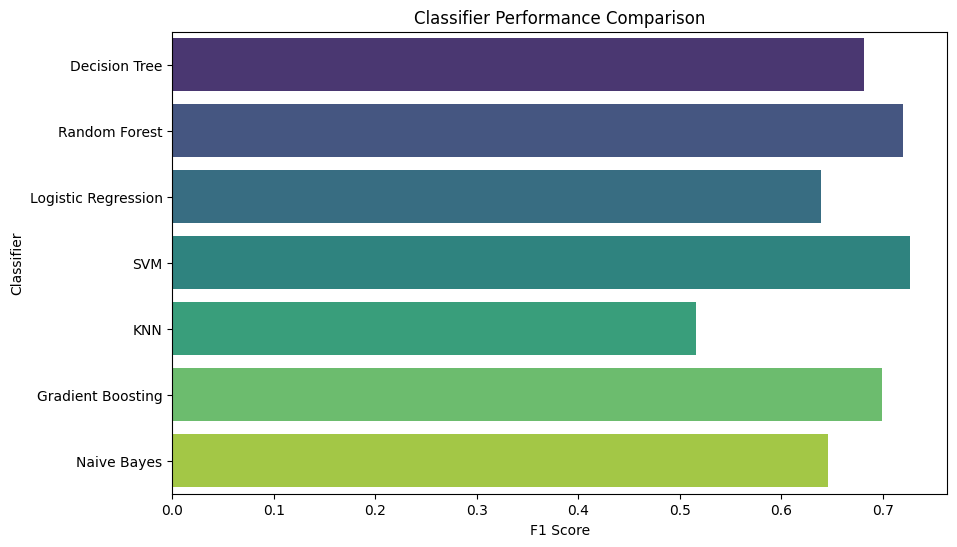

In [59]:
# Define empty lists to store classifier names and their corresponding F1 scores
classifier_names = []
f1_scores = []

# Evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    classifier_names.append(name)
    f1_scores.append(score)

# Create a bar plot to visualize classifier performance
plt.figure(figsize=(10, 6))
sns.barplot(x=f1_scores, y=classifier_names, palette='viridis')
plt.xlabel('F1 Score')
plt.ylabel('Classifier')
plt.title('Classifier Performance Comparison')
plt.show()
